In [1]:
# Import external tools:
import time 
import random
from matplotlib import pyplot as plt
import librosa
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torch.utils.data.sampler import SubsetRandomSampler
from torchsummary import summary
import torchaudio
import soundfile as sf
from scipy import signal
import getpass
import pandas as pd
import numpy as np
import sys
import os
import importlib
from scipy.io import wavfile
from IPython.display import Audio
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# I am running this script on two different computers, so i need to change paths
# depending on computer in use: 
if getpass.getuser()=="joanna.luberadzka":
    projectdir="/Users/joanna.luberadzka/Documents/VAE-IR/"
    datadir="/Users/joanna.luberadzka/Documents/Data/IR_Arni_upload_numClosed_0-5/"
elif getpass.getuser()=="ubuntu":
    projectdir="/home/ubuntu/joanna/VAE-IR/"
    datadir="/home/ubuntu/Data/IR_Arni_upload_numClosed_0-5/"

# Add path of this project
sys.path.insert(0, projectdir+'src/')

# Import and automatically reload my own modules:
import models; importlib.reload(models)
import train; importlib.reload(train)
import datasetprep as dsprep; importlib.reload(dsprep)
import helpers; importlib.reload(helpers)

<module 'helpers' from '/home/ubuntu/joanna/VAE-IR/src/helpers.py'>

In [19]:

# load trained model:
model=models.VAE_Lin(x_len=24000)
model.load_state_dict(torch.load(projectdir + "models/trained_model_30-01-2023--17-01.pth"))
# put the model in evaluation mode
model.eval()

# data:
if getpass.getuser()=="joanna.luberadzka":
    INFO_FILE = projectdir + "irstats_ARNIandBUT_datura.csv"
elif getpass.getuser()=="ubuntu":
    INFO_FILE = projectdir+"irstats_ARNIandBUT_datura.csv"

SAMPLING_RATE=8e3
# instantiate data set 
dataset = dsprep.DatasetRirs(INFO_FILE,SAMPLING_RATE)


# *** Encoding: Using a trained variational autoencoder model, 
# generate a lower-dimensional embedding for each impulse response.

embeddings_mu=[] # list for storing ir embeddings
embeddings_rt=[] # list for storing rt values
embeddings_drr=[] # list for storing drr values

# take 100 random irs from the data set
ir_rand_indices=random.sample(range(len(dataset)),100)

for i in ir_rand_indices:
    # get info of an impulse response with a specific index
    ir, labels= dataset[i]
    # encode the input into mu and sigma (standard in VAE)
    mu, sigma = model.encode(ir)
    # mu is the embedding (sigma provides additional info about the uncertainty of this embedding)   
    emb = mu.squeeze(dim=0) 
    # convert to numpy array and append the list of embeddings
    embeddings_mu.append(emb.detach().cpu().numpy())
    embeddings_rt.append(labels["rt"])
    embeddings_drr.append(labels["drr"])

# covert from list of arrays to one array
embeddings_mu=np.array(embeddings_mu)



In [20]:
print(embeddings_mu[1])
print(embeddings_mu[2])
print(embeddings_mu[30])

[-5.5775046e-05 -5.4929405e-05 -1.2648851e-04 -1.8469989e-05
 -4.5292079e-05 -7.3164701e-06 -2.6520714e-04 -9.2893839e-05
 -1.9162893e-05  3.5941601e-05 -2.0563602e-05 -8.4578991e-05
  4.9933791e-05  8.3841383e-05  4.7937036e-05  9.5590949e-06
  2.3826957e-05  2.6520342e-05 -9.9837780e-06  5.0030649e-05
  2.0414591e-06  4.0469691e-05 -3.4075230e-05  6.9808215e-05]
[-5.5775046e-05 -5.4929405e-05 -1.2648851e-04 -1.8469989e-05
 -4.5292079e-05 -7.3164701e-06 -2.6520714e-04 -9.2893839e-05
 -1.9162893e-05  3.5941601e-05 -2.0563602e-05 -8.4578991e-05
  4.9933791e-05  8.3841383e-05  4.7937036e-05  9.5590949e-06
  2.3826957e-05  2.6520342e-05 -9.9837780e-06  5.0030649e-05
  2.0414591e-06  4.0469691e-05 -3.4075230e-05  6.9808215e-05]
[-5.5775046e-05 -5.4929405e-05 -1.2648851e-04 -1.8469989e-05
 -4.5292079e-05 -7.3164701e-06 -2.6520714e-04 -9.2893839e-05
 -1.9162893e-05  3.5941601e-05 -2.0563602e-05 -8.4578991e-05
  4.9933791e-05  8.3841383e-05  4.7937036e-05  9.5590949e-06
  2.3826957e-05  2.652

/home/ubuntu/joanna/venvs/testenv/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var


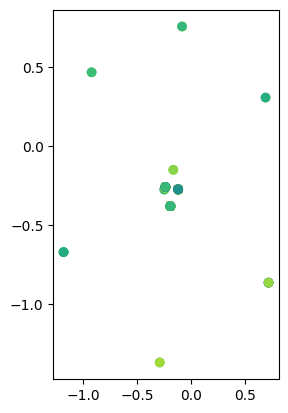

In [21]:

# *** Visualization: To visualize each encoding, the D-dimensional embeddings 
# have to be reduced to 2 dimensions. This can be done with two methods: 
# PCA (linear) or TSNE (non-linear)
embeddings_pca=PCA(n_components=2).fit_transform(embeddings_mu)
embeddings_tsne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=30).fit_transform(embeddings_mu)

# plt.figure()
# plt.subplot(1,2,1)
# plt.scatter(embeddings_pca[:,0] , embeddings_pca[:,1])
# plt.subplot(1,2,2)
# plt.scatter(embeddings_pca[:,0] , embeddings_pca[:,1])

plt.figure()
plt.subplot (1,2,1)
plt.scatter(embeddings_tsne[:,0] , embeddings_tsne[:,1], c=embeddings_rt)
plt.scatter(embeddings_tsne[:,0] , embeddings_tsne[:,1], c=embeddings_drr)


# # use pca init for repeatable results
# pca      = PCA(n_components=2)
# x_reduce = pca.fit_transform(z_df)


# emb_tsne = TSNE(n_components=2, learning_rate='auto').fit_transform(embeddings.detach().cpu().numpy())
# plt.scatter(emb_tsne[:,0] , emb_tsne[:,1], c=category_mappings)
# plt.show()


# pick a random IRs for each IR choose the closest and the furthest embedding from the set of embeddings. 

# get info of an impulse response with a specific index
# print("filename= "+ IrData["filepath"][2])
# print("rt= "+ str(IrData["rt"][2]))
# print("drr= "+ str(IrData["drr"][2]))

# convolve signal with a closest and furthest ir - the one with closest should sound similar and the one with furthest should sound different

# y = signal.fftconvolve(x, h, mode = 'full')
# sf.write("convolved.wav", y.T, sr_h, subtype='PCM_24')
# sf.write("anechoic.wav", x.T, sr_h, subtype='PCM_24')



# # plot parameters of impulse responses in the data  
# fig, ax = plt.subplots()
# ax.scatter(x=IrData["rt"][0:11331], y=IrData["drr"][0:11331],label="Arni", alpha=0.2)
# ax.scatter(x=IrData["rt"][11331:], y=IrData["drr"][11331:],label="BUT",alpha=0.2)
# plt.xlabel("T60")
# plt.ylabel("DRR")
# plt.legend()
# ax.set(title="Two IR data bases")
# plt.show()

# fig, ax = plt.subplots()
# ax.scatter(x=IrData["rt"], y=IrData["drr"],c=IrData["cte"], alpha=0.2)
# sc1=plt.xlabel("T60")
# sc2=plt.ylabel("DRR")
# ax.set(title="Early to late reflections (CTE) ")
# plt.show()

# fig, ax = plt.subplots()
# ax.scatter(x=IrData["rt"], y=IrData["drr"],c=IrData["edt"], alpha=0.2)
# plt.xlabel("T60")
# plt.ylabel("DRR")
# ax.set(title="Early decay time (EDT)")
# plt.show()

In [ ]:
# get info of an impulse response with a specific index
filename= IrData["filepath"][1200]
# load chosen RIR
h, sr_h= torchaudio.load(filename)
# load anechoic sound file
x, sr_x=torchaudio.load("anechoic.wav")
# resample anechoic signal
x=torchaudio.transforms.Resample(sr_x,sr_h)(x)
# convolve anechoic signal with RIR: y=x*h
y = signal.fftconvolve(x, h, mode = 'full')
# set signal levels
x=x.numpy()
x=helpers.set_level(x,-30)
y=helpers.set_level(y,-30)
# save signals
sf.write("convolved.wav", y.T, sr_h, subtype='PCM_24')
sf.write("anechoic.wav", x.T, sr_h, subtype='PCM_24')

In [ ]:
Audio('convolved.wav')

In [ ]:
Audio('anechoic.wav')